## Improving accuracy through mesh refinement (uniform h-refinement)
## H-refinement: using more of the same elements by uniformly making elements smaller, i.e. same element approximates over a smaller domain
## Another refinement is P-refinement (polynomial refinement), i.e. making the order of the polynomial higher
## Another refinement is R-refinement, i.e. using the same number of elements but some big and some small
## Adapted from Example 3.7 Prescribed Textbook
## Solving the prescribed textbook example using consistent nodal loads using Python Sympy

Matrix([[6666666.66666667, -7619047.61904762, 952380.952380952, 0, 0], [-7619047.61904762, 15238095.2380952, -7619047.61904762, 0, 0], [952380.952380952, -7619047.61904762, 6666666.66666667, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
Assmebled global stiffness matrix Matrix([[6666666.66666667, -7619047.61904762, 952380.952380952, 0, 0], [-7619047.61904762, 15238095.2380952, -7619047.61904762, 0, 0], [952380.952380952, -7619047.61904762, 13333333.3333333, -7619047.61904762, 952380.952380952], [0, 0, -7619047.61904762, 15238095.2380952, -7619047.61904762], [0, 0, 952380.952380952, -7619047.61904762, 6666666.66666667]]):
Assmebled global load vector Matrix([[14.5653260869565], [58.2613043478261], [58.2613043478261], [174.783913043478], [43.6959782608696]]):
Displacement vector Matrix([[0], [5.73509714673913e-5], [0.000107055146739130], [0.000141465729619565], [0.000152935923913043]])


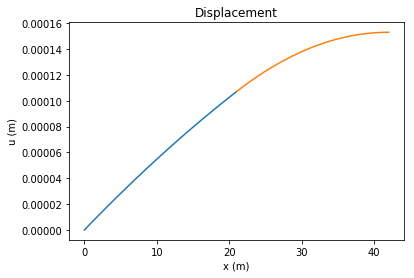

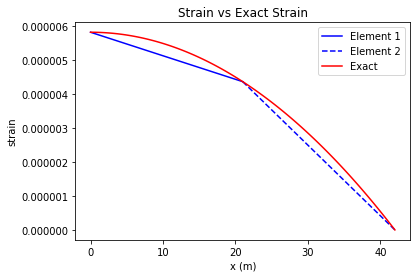

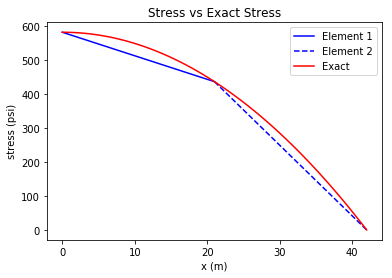

In [2]:
import numpy as np
import sympy as sp
xi = sp.symbols('xi')


# Nodes in global coordinate system is numbered from left to right: 1 2 3 4 5 
elements = [[1,3,2],[3,5,4]] # Global bode numbers that make up each element
# Recall each quadratic element is numbered [left node, right nodde, middle node]

# Global coordinates that make up each element
x1 = 0
x2 = 10.5
x3 = 21
x4 = 31.5
x5 = 42

# Properties for example problem as stated in prescribed textbook
A = 0.6
E = 10E7 # psi
g_feet = 32.2 # feet/s^2
g = g_feet*12 # in/s^2 here in inches
rho = 0.2836 # weight density
omega = 30
L1 = x3-x1
L2 = x5-x3

# Compute non-zero surface traction
# E constant, A constant - hence can use closed form computed elements
k1 = E*A/(3*L1)*sp.Matrix([[7,1,-8],[1,7,-8],[-8,-8,16]]) 
k2 = E*A/(3*L2)*sp.Matrix([[7,1,-8],[1,7,-8],[-8,-8,16]])

# Textbook simplifies body force as constant over each element
f1 = 0.6*21*0.2836*10.5*30**2/(32.2*12)*sp.Matrix([1/6,1/6,2/3])
f2 = 0.6*21*0.2836*31.5*30**2/(32.2*12)*sp.Matrix([1/6,1/6,2/3])

Kglobal = sp.zeros(5,5)
n = 0
for i in elements[0]: # Assemble elements[0] = [1 3 2]
    m = 0
    for j in elements[0]:
        Kglobal[i-1,j-1] = Kglobal[i-1,j-1] + k1[n,m]
        m = m + 1
    n = n + 1
print(Kglobal)

n = 0
for i in elements[1]: # Assemble elements[1] = [3,5,4]
    m = 0
    for j in elements[1]:
        Kglobal[i-1,j-1] = Kglobal[i-1,j-1] + k2[n,m]
        m = m + 1
    n = n + 1
print('Assmebled global stiffness matrix {}:'.format(Kglobal))

Fglobal = sp.zeros(5,1)
n = 0
for i in elements[0]: #Assemble body force over first element
    Fglobal[i-1] = Fglobal[i-1] + f1[n]
    n = n + 1

n = 0
for i in elements[1]: #Assemble body force over second element
    Fglobal[i-1] = Fglobal[i-1] + f2[n]
    n = n + 1

print('Assmebled global load vector {}:'.format(Fglobal))

qunknown = Kglobal[1:,1:].solve(Fglobal[1:,0]-Kglobal[1:,0]*0);
q = sp.Matrix.vstack(sp.Matrix([0]),qunknown) # construct full displacement vector including the known displacement q = 0

print('Displacement vector {}'.format(q))
# Shape fucntiosn are requird to map xi to x for plotting over the actual domain
# Note xi is a symbolic variable by choice
N1 = -1/2*xi*(1-xi); N2 = 1/2*xi*(1+xi); N3 = (1 - xi)*(1 + xi); N = [N1,N2,N3]
X1 = N1*x1 + N2*x3 + N3*x2 # Map of xi to x for element 1
X2 = N1*x3 + N2*x5 + N3*x4 # Map of xi to x for element 2

U1 = q[list(np.array(elements[0])-1),:].dot(sp.Matrix(N))  # Sorry for this ugly line: list(np.array(elements[0])-1)
# Since my numbers start at 1 to 5 but Python indexes need to start at 0 up to 4 - I need to subtract 1 from each 
# node value in the element list. All I do here is, I make the list a numpy array subtract 1 and make it a list again.
U2 = q[list(np.array(elements[1])-1),:].dot(sp.Matrix(N))

exx1 = q[list(np.array(elements[0])-1),:].dot(2/L1*sp.derive_by_array(N,xi))
exx2 = q[list(np.array(elements[1])-1),:].dot(2/L2*sp.derive_by_array(N,xi))

# Convert symbolic expressions to numerical expression for plotting using matplotlib
X1n = sp.lambdify(xi,X1)
X2n = sp.lambdify(xi,X2)

U1n = sp.lambdify(xi,U1)
U2n = sp.lambdify(xi,U2)

exx1n = sp.lambdify(xi,exx1)
exx2n = sp.lambdify(xi,exx2)

L = x1-x5
x = np.linspace(x1,x5,121)
stress_exact = rho*omega**2/(2*g)*(L**2 - x**2)
strain_exact = stress_exact/E

xi = np.linspace(-1,1,21)
import matplotlib.pyplot as plt
plt.plot(X1n(xi),U1n(xi))
plt.plot(X2n(xi),U2n(xi))
plt.title('Displacement')
plt.xlabel('x (m)')
plt.ylabel('u (m)')

plt.show()

plt.plot(X1n(xi),exx1n(xi),'b-',label="Element 1")
plt.plot(X2n(xi),exx2n(xi),'b--',label="Element 2")
plt.plot(x,strain_exact,'r-',label="Exact")
plt.title('Strain vs Exact Strain')
plt.xlabel('x (m)')
plt.ylabel('strain')

plt.legend(loc="best")
plt.show()

plt.plot(X1n(xi),E*exx1n(xi),'b-',label="Element 1")
plt.plot(X2n(xi),E*exx2n(xi),'b--',label="Element 2")
plt.plot(x,stress_exact,'r-',label="Exact")
plt.title('Stress vs Exact Stress')
plt.xlabel('x (m)')
plt.ylabel('stress (psi)')

plt.legend(loc="best")
plt.show()